In [2]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.transforms import CenterCrop, Resize

# 시작 시간 기록
start_time = time.time()

# 라벨 매핑 정의
# 라벨 매핑 정의
label_map = {
    'OH_FF': 0,  # 전방포커스, 밝은 조도 - 외부
    'IH_FF': 0,  # 전방포커스, 밝은 조도 - 내부
    'OL_FF': 1,  # 전방포커스, 어두운 조도 - 외부
    'IL_FF': 1,  # 전방포커스, 어두운 조도 - 내부

    'OH_RF': 2,  # 후방포커스, 밝은 조도 - 외부
    'IH_RF': 2,  # 후방포커스, 밝은 조도 - 내부
    'OL_RF': 3,  # 후방포커스, 어두운 조도 - 외부
    'IL_RF': 3,  # 후방포커스, 어두운 조도 - 내부

    'OH_RL': 4,  # 좌우흔들림, 밝은 조도 - 외부
    'IH_RL': 4,  # 좌우흔들림, 밝은 조도 - 내부
    'OL_RL': 5,  # 좌우흔들림, 어두운 조도 - 외부
    'IL_RL': 5,  # 좌우흔들림, 어두운 조도 - 내부

    'OH_UD': 6,  # 위아래흔들림, 밝은 조도 - 외부
    'IH_UD': 6,  # 위아래흔들림, 밝은 조도 - 내부
    'OL_UD': 7,  # 위아래흔들림, 어두운 조도 - 외부
    'IL_UD': 7,  # 위아래흔들림, 어두운 조도 - 내부

    'OH_LE': 8,  # 렌즈이물질, 밝은 조도 - 외부
    'IH_LE': 8,  # 렌즈이물질, 밝은 조도 - 내부
    'OL_LE': 9,  # 렌즈이물질, 어두운 조도 - 외부
    'IL_LE': 9,  # 렌즈이물질, 어두운 조도 - 내부

    'OH_DU': 10,  # 먼지, 밝은 조도 - 외부
    'IH_DU': 10,  # 먼지, 밝은 조도 - 내부
    'OL_DU': 11,  # 먼지, 어두운 조도 - 외부
    'IL_DU': 11,  # 먼지, 어두운 조도 - 내부

    'OH_SC': 12,  # 스크래치, 밝은 조도 - 외부
    'IH_SC': 12,  # 스크래치, 밝은 조도 - 내부
    'OL_SC': 13,  # 스크래치, 어두운 조도 - 외부
    'IL_SC': 13,  # 스크래치, 어두운 조도 - 내부

    'OH_FL': 14,  # 자유흔들림, 밝은 조도 - 외부
    'IH_FL': 14,  # 자유흔들림, 밝은 조도 - 내부
    'OL_FL': 15,  # 자유흔들림, 어두운 조도 - 외부
    'IL_FL': 15,  # 자유흔들림, 어두운 조도 - 내부

    'OH_LB': 16,  # 제문얼룩, 밝은 조도 - 외부
    'IH_LB': 16,  # 제문얼룩, 밝은 조도 - 내부
    'OL_LB': 17,  # 제문얼룩, 어두운 조도 - 외부
    'IL_LB': 17,  # 제문얼룩, 어두운 조도 - 내부

    'OH_RB': 18,  # 우측변짐, 밝은 조도 - 외부
    'IH_RB': 18,  # 우측변짐, 밝은 조도 - 내부
    'OL_RB': 19,  # 우측변짐, 어두운 조도 - 외부
    'IL_RB': 19   # 우측변짐, 어두운 조도 - 내부
}

class CustomDataset(Dataset):
    def __init__(self, noisy_image_paths, transform=None):
        self.noisy_image_paths = [os.path.join(noisy_image_paths, x) for x in os.listdir(noisy_image_paths)]
        self.transform = transform
        self.center_crop = CenterCrop(1080)
        self.resize = Resize((224, 224), Image.BICUBIC)
        self.noisy_label_pairs = self._create_noisy_label_pairs()

    def _create_noisy_label_pairs(self):
        noisy_label_pairs = []
        for image_file in self.noisy_image_paths:
            if image_file.endswith(('jpg', 'png', 'jpeg')):  # 이미지 파일 형식 확인
                parts = os.path.basename(image_file).split('_')
                
                # 조도 정보와 라벨 정보 추출
                lighting_key = parts[2][:2]  # "OH", "IH", "OL", "IL" 등 조도 부분
                label_key = parts[-1].split('.')[0]  # "FF", "RF", "RL" 등 포커스 부분
                
                # 조합 레이블 생성 (조도 정보가 앞에 오도록)
                combined_label = f"{lighting_key}_{label_key}"
                label = label_map.get(combined_label)
                
                if label is not None:
                    noisy_label_pairs.append((image_file, label))

        return noisy_label_pairs

    def __len__(self):
        return len(self.noisy_label_pairs)

    def __getitem__(self, index):
        noisy_image_path, noisy_label = self.noisy_label_pairs[index]
        noisy_image = Image.open(noisy_image_path).convert("RGB")

        # 이미지 전처리
        noisy_image = self.center_crop(noisy_image)
        noisy_image = self.resize(noisy_image)

        if self.transform:
            noisy_image = self.transform(noisy_image)

        return noisy_image, noisy_label  # noisy_label만 반환

In [ ]:
# 하이퍼파라미터 설정

batch_size = 64


# Dataset paths
train_root_dir = '/home/cvmlserver4/minjun/Uni-D-Datathon-4th/event/Training/noisy'  # Update with your actual training data path
val_root_dir = '/home/cvmlserver4/minjun/Uni-D-Datathon-4th/event/Validation/noisy'  # Update with your actual validation data path
# 데이터셋 로드 및 전처리
train_transform = Compose([
    ToTensor(),
])
# Create datasets and dataloaders
num_cores = os.cpu_count()
train_dataset = CustomDataset(train_root_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=int(num_cores/2), shuffle=True)
print("train",len(train_dataset))

val_dataset = CustomDataset(val_root_dir, transform=train_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=int(num_cores/2), shuffle=False)
print("valid",len(val_dataset))


train 15752
valid 1932


In [5]:
from tqdm import tqdm
from torchvision import models
num_epochs = 10
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 20)  # Set output size to match number of classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

# Training and validation loop

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Add tqdm to training loader
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update tqdm description with current loss and accuracy
        train_loader_tqdm.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    train_loss = running_loss / len(train_dataset)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Add tqdm to validation loader
    val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Update tqdm description with current loss and accuracy
            val_loader_tqdm.set_postfix(loss=loss.item(), accuracy=100 * val_correct / val_total)

    val_loss = val_loss / len(val_dataset)
    val_accuracy = 100 * val_correct / val_total

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save model after all epochs are completed
torch.save(model.state_dict(), 'resnet18_mid.pth')
print("Model saved after completing all epochs.")


/home/cvmlserver4/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cvmlserver4/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Training]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.8602, Train Accuracy: 70.34%, Validation Loss: 0.9360, Validation Accuracy: 67.91%


Epoch [2/10], Train Loss: 0.4996, Train Accuracy: 81.64%, Validation Loss: 0.5830, Validation Accuracy: 78.73%


Epoch [3/10], Train Loss: 0.3828, Train Accuracy: 85.77%, Validation Loss: 0.7805, Validation Accuracy: 76.19%


Epoch [4/10], Train Loss: 0.3312, Train Accuracy: 87.79%, Validation Loss: 0.4393, Validation Accuracy: 84.42%


Epoch [5/10], Train Loss: 0.2655, Train Accuracy: 90.22%, Validation Loss: 0.5315, Validation Accuracy: 79.45%


Epoch [6/10], Train Loss: 0.2515, Train Accuracy: 90.62%, Validation Loss: 0.4369, Validation Accuracy: 84.37%


Epoch [7/10], Train Loss: 0.2029, Train Accuracy: 92.25%, Validation Loss: 0.4215, Validation Accuracy: 86.54%


Epoch [8/10], Train Loss: 0.2200, Train Accuracy: 91.81%, Validation Loss: 0.6878, Validation Accuracy: 80.49%


Epoch [9/10], Train Loss: 0.1613, Train Accuracy: 93.97%, Validation Loss: 0.3390, Validation Accuracy: 87.99%


Epoch [10/10], Train Loss: 0.1328, Train Accuracy: 94.98%, Validation Loss: 0.4143, Validation Accuracy: 86.13%
Model saved after completing all epochs.


In [ ]:
from tqdm import tqdm
from torchvision import models
import torch.optim as optim
import torch.nn as nn
import torch

# Set hyperparameters
num_epochs = 10
learning_rate = 1e-4  # Adjusted learning rate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and modify the final layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 20)  # Set output size to match the number of classes
model = model.to(device)

# Load the saved model weights
model.load_state_dict(torch.load('resnet18_mid.pth'))
print("Model loaded successfully.")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Add tqdm to training loader
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update tqdm description with current loss and accuracy
        train_loader_tqdm.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    train_loss = running_loss / len(train_dataset)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Add tqdm to validation loader
    val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Update tqdm description with current loss and accuracy
            val_loader_tqdm.set_postfix(loss=loss.item(), accuracy=100 * val_correct / val_total)

    val_loss = val_loss / len(val_dataset)
    val_accuracy = 100 * val_correct / val_total

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save model after all epochs are completed
torch.save(model.state_dict(), 'resnet18_mid_continued.pth')
print("Model saved after completing all epochs.")


/home/cvmlserver4/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cvmlserver4/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

/home/cvmlserver4/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cvmlserver4/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully.


Testing:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 24.1254, Test Accuracy: 92.18%


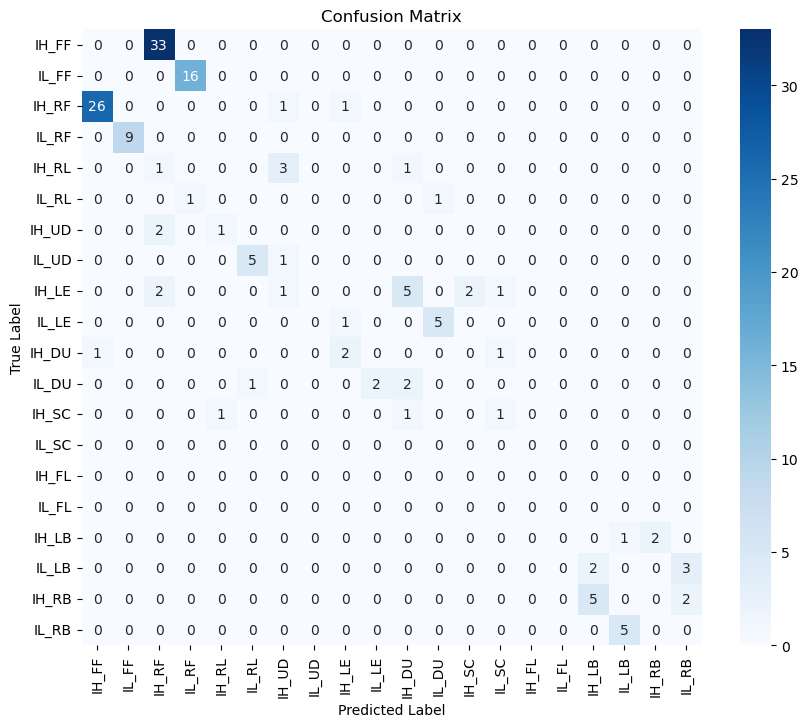

Overall Accuracy: 92.18%


In [7]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Label map reverse 정의
label_map_reverse = {
    0: 'OH_FF',  # 전방포커스, 밝은 조도 - 외부
    0: 'IH_FF',  # 전방포커스, 밝은 조도 - 내부
    1: 'OL_FF',  # 전방포커스, 어두운 조도 - 외부
    1: 'IL_FF',  # 전방포커스, 어두운 조도 - 내부

    2: 'OH_RF',  # 후방포커스, 밝은 조도 - 외부
    2: 'IH_RF',  # 후방포커스, 밝은 조도 - 내부
    3: 'OL_RF',  # 후방포커스, 어두운 조도 - 외부
    3: 'IL_RF',  # 후방포커스, 어두운 조도 - 내부

    4: 'OH_RL',  # 좌우흔들림, 밝은 조도 - 외부
    4: 'IH_RL',  # 좌우흔들림, 밝은 조도 - 내부
    5: 'OL_RL',  # 좌우흔들림, 어두운 조도 - 외부
    5: 'IL_RL',  # 좌우흔들림, 어두운 조도 - 내부

    6: 'OH_UD',  # 위아래흔들림, 밝은 조도 - 외부
    6: 'IH_UD',  # 위아래흔들림, 밝은 조도 - 내부
    7: 'OL_UD',  # 위아래흔들림, 어두운 조도 - 외부
    7: 'IL_UD',  # 위아래흔들림, 어두운 조도 - 내부

    8: 'OH_LE',  # 렌즈이물질, 밝은 조도 - 외부
    8: 'IH_LE',  # 렌즈이물질, 밝은 조도 - 내부
    9: 'OL_LE',  # 렌즈이물질, 어두운 조도 - 외부
    9: 'IL_LE',  # 렌즈이물질, 어두운 조도 - 내부

    10: 'OH_DU',  # 먼지, 밝은 조도 - 외부
    10: 'IH_DU',  # 먼지, 밝은 조도 - 내부
    11: 'OL_DU',  # 먼지, 어두운 조도 - 외부
    11: 'IL_DU',  # 먼지, 어두운 조도 - 내부

    12: 'OH_SC',  # 스크래치, 밝은 조도 - 외부
    12: 'IH_SC',  # 스크래치, 밝은 조도 - 내부
    13: 'OL_SC',  # 스크래치, 어두운 조도 - 외부
    13: 'IL_SC',  # 스크래치, 어두운 조도 - 내부

    14: 'OH_FL',  # 자유흔들림, 밝은 조도 - 외부
    14: 'IH_FL',  # 자유흔들림, 밝은 조도 - 내부
    15: 'OL_FL',  # 자유흔들림, 어두운 조도 - 외부
    15: 'IL_FL',  # 자유흔들림, 어두운 조도 - 내부

    16: 'OH_LB',  # 제문얼룩, 밝은 조도 - 외부
    16: 'IH_LB',  # 제문얼룩, 밝은 조도 - 내부
    17: 'OL_LB',  # 제문얼룩, 어두운 조도 - 외부
    17: 'IL_LB',  # 제문얼룩, 어두운 조도 - 내부

    18: 'OH_RB',  # 우측변짐, 밝은 조도 - 외부
    18: 'IH_RB',  # 우측변짐, 밝은 조도 - 내부
    19: 'OL_RB',  # 우측변짐, 어두운 조도 - 외부
    19: 'IL_RB'   # 우측변짐, 어두운 조도 - 내부
}


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and set up the model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 20)  # Adjust the output layer for 20 classes
model = model.to(device)
model.load_state_dict(torch.load('resnet18_final.pth'))
print("Model loaded successfully.")

# Set model to evaluation mode
model.eval()

# Assuming train_dataset has a way to access image paths
image_paths = train_dataset.noisy_image_paths  # Adjust this according to how you store paths in train_dataset

# Tracking for misclassified images
misclassified = []  # To store details of misclassified images
val_loss = 0.0
val_correct = 0
val_total = 0

# Testing loop with tqdm
val_loader_tqdm = tqdm(val_loader, desc="Testing", leave=False)
criterion = nn.CrossEntropyLoss()  # For reference only if needed

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader_tqdm):  # Remove paths from here
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        # Check for misclassified images
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                misclassified.append({
                    "image_path": image_paths[batch_idx * len(images) + i],  # Retrieve the path based on the index
                    "predicted_label": predicted[i].item(),
                    "true_label": labels[i].item()
                })

val_loss = val_loss / len(val_loader)
val_accuracy = 100 * val_correct / val_total

# Print test accuracy
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.2f}%")

# Confusion matrix 초기화
confusion_matrix = np.zeros((20, 20), dtype=int)

# Misclassified 통계를 기반으로 confusion matrix 채우기
for mis in misclassified:
    true_label = mis['true_label']
    predicted_label = mis['predicted_label']
    confusion_matrix[true_label][predicted_label] += 1

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map_reverse.values(), yticklabels=label_map_reverse.values())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# 정확도 출력
print(f"Overall Accuracy: {val_accuracy:.2f}%")


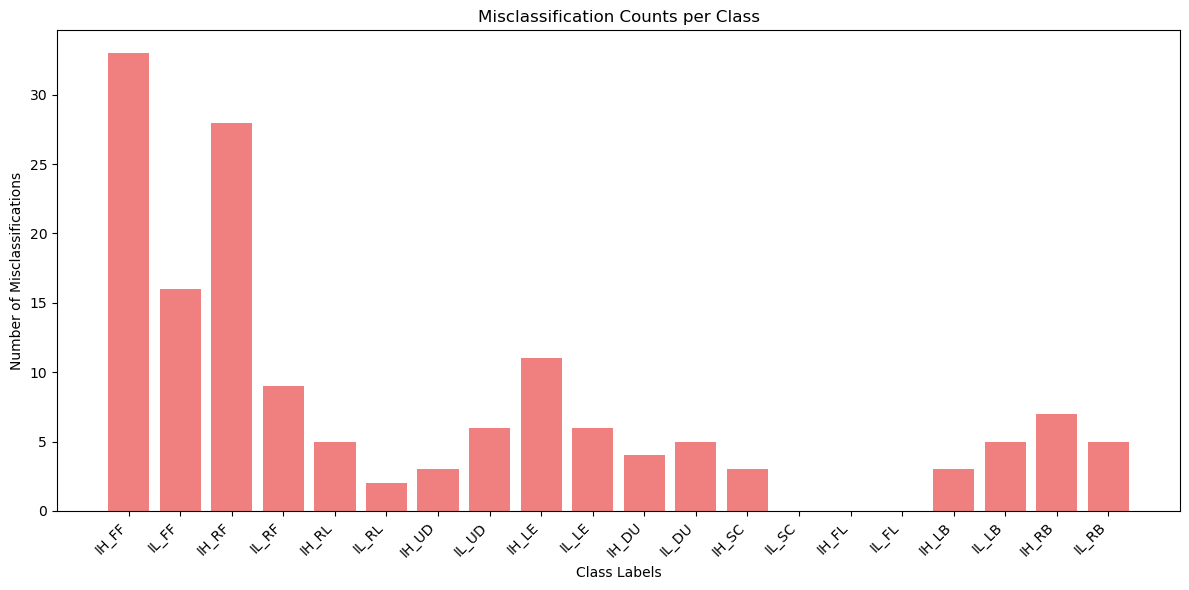

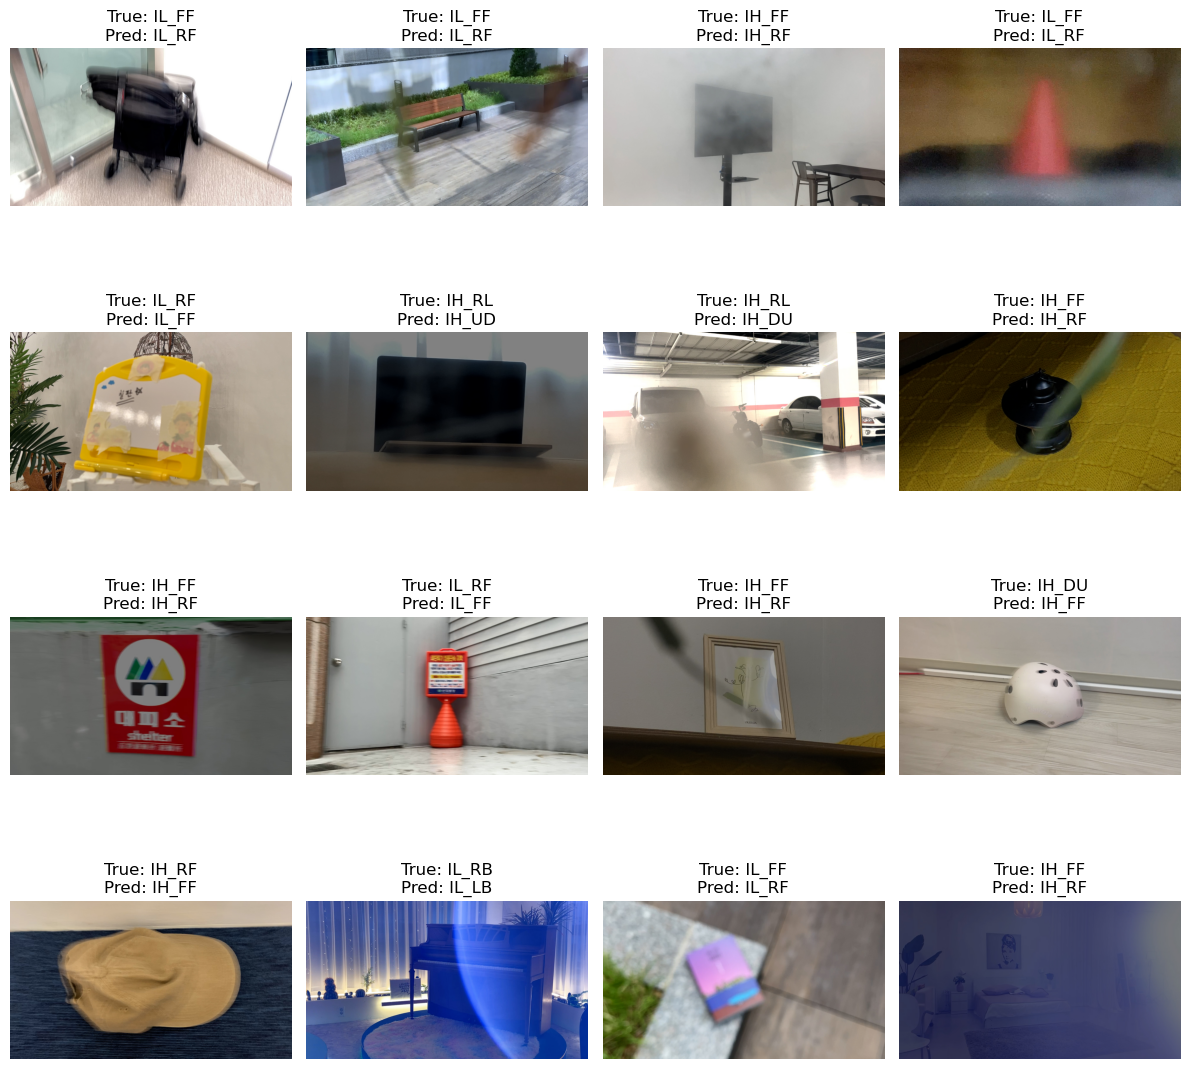

In [9]:
misclass_count = np.zeros(20, dtype=int)

for mis in misclassified:
    true_label = mis['true_label']
    misclass_count[true_label] += 1

# Plotting the misclassification counts
plt.figure(figsize=(12, 6))
class_names = list(label_map_reverse.values())
plt.bar(class_names, misclass_count, color='lightcoral')
plt.xlabel('Class Labels')
plt.ylabel('Number of Misclassifications')
plt.title('Misclassification Counts per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualizing only misclassified images
def visualize_misclassified(misclassified, n_images=16):
    """Visualizes misclassified images with true and predicted labels."""
    plt.figure(figsize=(12, 12))
    n_images = min(n_images, len(misclassified))
    for idx in range(n_images):
        mis = misclassified[idx]
        image_path = mis['image_path']
        true_label = label_map_reverse[mis['true_label']]
        predicted_label = label_map_reverse[mis['predicted_label']]
        
        # Load the image
        image = plt.imread(image_path)
        
        plt.subplot(4, 4, idx + 1)  # Adjust the grid size as needed
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize misclassified images
if misclassified:  # Only visualize if there are misclassified images
    visualize_misclassified(misclassified)
else:
    print("No misclassified images to display.")